# Gaussian Process Regression (with GPytorch)
This tutorial assumes familiarity with the following:
1. Bean Machine [modeling](#link) and [inference](#link)
2. [Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process)
3. [GPyTorch](https://gpytorch.ai/)

A Gaussian Process (GP) is a stochastic process commonly used in Bayesian non-parametrics, whose finite collection of random variables follow a multivariate Gaussian distribution.  GPs are fully defined by a mean and covariance function:

$$f \sim \mathcal{GP}\left(\mu(x), \mathbf{K}_f(x, x')\right)$$

where  $x, x' \in\mathbf{X}$ are two data points (e.g. train and test), $\mu$ is the mean function (usually taken to be zero or constant), and $\mathbf{K}_f$ is the kernel function, which computes a covariance given two datapoints and a distance metric.

The aim is then to fit a posterior over *functions*.  GPs allow us to learn a distribution over functions given our observed data and predict unseen data with well-calibrated uncertainty, and is commonly used in Bayesian Optimization as a surrogate function to maximize an objective. For a thorough introduction to Gaussian processes, please see [1]

With a PPL such as Bean Machine, we can be Bayesian about the parameters we care about, i.e. learn posterior distributions over these parameters rather than a point estimate.

In [1]:
import math
import copy
from functools import partial

import torch
import torch.distributions as dist

import beanmachine
import beanmachine.ppl as bm
from beanmachine.ppl.inference.single_site_no_u_turn_sampler import SingleSiteNoUTurnSampler
import beanmachine.ppl.experimental.gp as bgp
from beanmachine.ppl.experimental.gp.models import SimpleGP

import gpytorch
from gpytorch.kernels import Kernel
from gpytorch.distributions import MultivariateNormal

import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(123)
print('pytorch version: ', torch.__version__)
print('gpytorch version: ', gpytorch.__version__)
# print('beanmachine version: ', beanmachine.__version__)


Bad key "axes.color_cycle" on line 214 in
/home/jpchen/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


pytorch version:  1.8.0a0fb
gpytorch version:  1.3.0


Let's use some simple cyclic data:

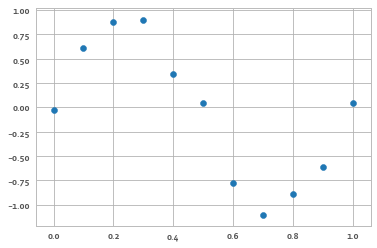

In [2]:
x_train = torch.linspace(0, 1, 11)
y_train = torch.sin(x_train * (2 * math.pi)) + torch.randn(x_train.shape) * 0.2
x_test = torch.linspace(0, 1, 51).unsqueeze(-1)

with torch.no_grad():
    plt.scatter(x_train.numpy(), y_train.numpy())
    plt.show()

Since this data has a periodic trend to it, we will use a Periodic Kernel:

$$k(x, x') = \sigma^2 \exp\Big(-\frac{2}{\ell}\sin^2\Big(\pi\frac{|x - x'|}{p}\Big)\Big)$$

where $p$, $\ell$, $\sigma^2$ are the periodicity, lengthscale, and outputscale of the function respectively, the (hyper)parameters of the kernel we want to learn.



## MAP Estimation (with GPyTorch)
GPytorch's exact inference algorithms allow you to compute maximum a posteriori (MAP) estimates of kernel parameters. Since a `SimpleGP` extends a GPytorch ExactGP model, you can use GPytorch to optimize the model. Let's try that, closely following the [GPytorch regression tutorial](https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html).

In [3]:
class Regression(SimpleGP):
    def __init__(self,
                 x_train,
                 y_train,
                 mean,
                 kernel,
                 likelihood,
                 *args,
                 **kwargs):
        super().__init__(x_train, y_train, mean, kernel, likelihood)

    def forward(self, data, batch_shape=()):
        """
        Computes the GP prior given data. This method should always
        return a `torch.distributions.MultivariateNormal`
        """
        shape = data.shape[len(batch_shape)]
        jitter = torch.eye(shape, shape) * 1e-5
        for _ in range(len(batch_shape)):
            jitter = jitter.unsqueeze(0)
        if isinstance(self.mean, gpytorch.means.Mean): 
            # demo using gpytorch for MAP estimation
            mean = self.mean(data)
        else:
            # use Bean Machine for learning posteriors
            if self.training:
                mean = self.mean(batch_shape).expand(data.shape[len(batch_shape):])
            else:
                mean = self.mean.expand(data.shape[:-1]) # overridden for evaluation
        cov = self.kernel(data) + jitter
        return MultivariateNormal(mean, cov)

In [4]:
kernel = gpytorch.kernels.ScaleKernel(base_kernel=gpytorch.kernels.PeriodicKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()
mean = gpytorch.means.ConstantMean()
gp = Regression(x_train, y_train, mean, kernel, likelihood)

In [5]:
optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
gp.eval()  # this converts the BM model into a gpytorch model
for i in range(100):
    optimizer.zero_grad()
    output = gp(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (
              i + 1, 100, loss.item(),
             ))
    optimizer.step()

Iter 1/100 - Loss: 1.082
Iter 11/100 - Loss: 0.504
Iter 21/100 - Loss: 0.040
Iter 31/100 - Loss: -0.385
Iter 41/100 - Loss: -0.755
Iter 51/100 - Loss: -0.939
Iter 61/100 - Loss: -0.947
Iter 71/100 - Loss: -0.966
Iter 81/100 - Loss: -0.959
Iter 91/100 - Loss: -0.954


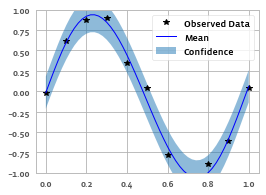

In [6]:
with torch.no_grad():
    observed_pred = likelihood(gp(x_test))
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test.squeeze().numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1, 1])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

Not bad! Our GP fits this simple function fairly well. However, we've only captured data uncertainty, not parameter uncertainty. It can often be the case that calibrating parameter uncertainty may lead to better predictive performance.  In the next section, we'll do just that using Bean Machine's NUTS algorithm.

## Fully Bayesian Inference with Bean Machine

Let's reuse the same model, but this time, use Bean Machine to learn posteriors over the parameters.  In `train` mode, `SimpleGP` is a simple wrapper around `gpytorch.models.ExactGP` that lifts learnable parameters to BM random variables.  Next, lets define our parameters $p$, $\sigma^2$, and $\ell$ in addition to mean and observation noise as random variables with the priors they are sampled from.

In [8]:
@bm.random_variable
def outputscale():
    return dist.Uniform(torch.tensor(1.), torch.tensor(2.))

@bm.random_variable
def lengthscale():
    return dist.Uniform(torch.tensor([0.01]), torch.tensor([0.5]))

@bm.random_variable
def period_length():
    return dist.Uniform(torch.tensor([0.05]), torch.tensor([2.5]))

@bm.random_variable
def noise():
    return dist.Uniform(torch.tensor([0.05]), torch.tensor([0.3]))

@bm.random_variable
def mean(batch_shape=()):
    batch_shape += (1,)
    a = -1 * torch.ones(batch_shape)
    b = torch.ones(batch_shape)
    return dist.Uniform(a, b)


Similarly, we'll create kernel and likelihood objects, this time passing our random variables as the hyperparameters. Note that the kernels are `beanmachine.kernels` instead of `gpytorch.kernels`.

In [9]:
kernel = bgp.kernels.ScaleKernel(
            base_kernel=bgp.kernels.PeriodicKernel(period_length_prior=period_length,
                                                   lengthscale_prior=lengthscale),
            outputscale_prior=outputscale
        )
likelihood = bgp.likelihoods.GaussianLikelihood(noise_prior=noise)

gp = Regression(x_train, y_train, mean, kernel, likelihood)

Now we can run inference as we would with any other Bean Machine model.

In [10]:
num_samples = 100

# bind the data to the forward call so it can be invoked in the likelihood
gp_prior = partial(gp, x_train)
obs = {gp.likelihood(gp_prior): y_train}

nuts = SingleSiteNoUTurnSampler()
samples = nuts.infer([mean(), lengthscale(), period_length(),
                      outputscale(), noise()],
                     obs,
                     num_samples=num_samples,
                     num_adaptive_samples=10,
                     num_chains=1)

Samples collected: 100%|██████████| 110/110 [01:26<00:00,  1.27it/s]


Let's take a look at how our model fit. We will plot the samples of our posterior as well as the predictives generated from our GP.

In [11]:
from beanmachine.ppl.diagnostics.diagnostics import Diagnostics
Diagnostics(samples).summary()

,avg,std,2.5%,50%,97.5%,n_eff
lengthscale()[0],0.140125,0.089507,0.037595,0.106262,0.410857,7.844890
mean()[0],-0.162350,0.556092,-0.974967,-0.228396,0.909371,27.333786
noise()[0],0.173884,0.072550,0.056716,0.162161,0.289424,43.890709
outputscale()[],1.479377,0.332293,1.005214,1.388878,1.993897,28.625566
period_length()[0],1.722287,0.481485,0.514152,1.807532,2.364764,10.685102


In [12]:
lengthscale_samples = samples.get_chain(0)[lengthscale()]
outputscale_samples = samples.get_chain(0)[outputscale()]
period_length_samples = samples.get_chain(0)[period_length()]
mean_samples = samples.get_chain(0)[mean()]
noise_samples = samples.get_chain(0)[noise()]

/mnt/xarfuse/uid-214705/fc34591a-seed-nspid4026531836-ns-4026531840/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



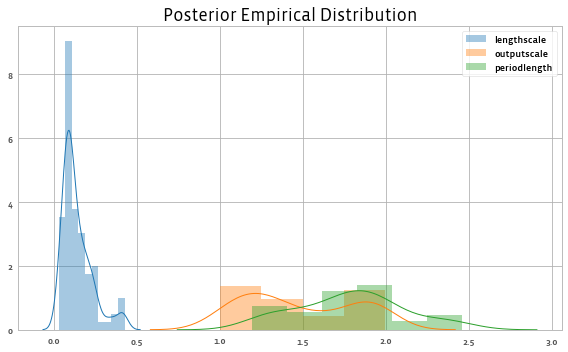

In [13]:
plt.figure(figsize=(8, 5))
sns.distplot(lengthscale_samples, label='lengthscale')
sns.distplot(outputscale_samples, label='outputscale')
sns.distplot(period_length_samples[:int(num_samples/2)], label='periodlength')
plt.legend()
plt.title("Posterior Empirical Distribution", fontsize=18)
plt.tight_layout()
plt.show()


To generate predictions, we will convert our model to a Gpytorch model by running in `eval` mode. We load our posterior samples with a python dict, keyed on the parameter namespace and valued on the torch tensor of samples. Note the `unsqueeze`s to allow broadcasting of the data dimension to the right. 

In [14]:
gp.eval() # converts to Gpytorch model in eval mode
gp.bm_load_samples({'kernel.outputscale': outputscale_samples,
               'kernel.base_kernel.lengthscale': lengthscale_samples.unsqueeze(-1),
               'kernel.base_kernel.period_length': period_length_samples.unsqueeze(-1),
               'likelihood.noise': noise_samples,
               'mean': mean_samples,
              })
expanded_x_test = x_test.unsqueeze(0).repeat(num_samples, 1, 1)
output = gp(expanded_x_test.detach(), batch_shape=(num_samples,))

Now we let's plot a few predictive samples from our GP. As you can see, we can draw different kernels, each of which paramaterizes a Multivariate Normal.

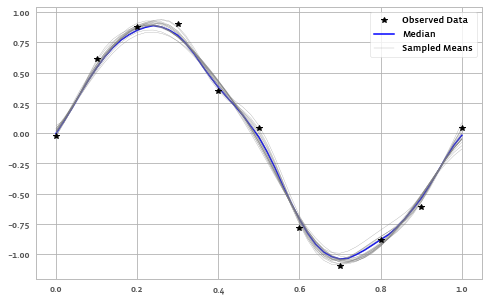

In [15]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*', zorder=10)
    ax.plot(x_test.numpy(), output.mean.median(0)[0].detach().numpy(), 'b', linewidth=1.5)
    for i in range(min(20, num_samples)):
        ax.plot(x_test.numpy(), output.mean[i].detach().numpy(), 'gray', linewidth=0.3, alpha=0.8)
    ax.legend(['Observed Data', 'Median', 'Sampled Means'])

## References
[1] Rasmussen, Carl and Williams, Christopher. **Gaussian Processes for Machine Learning**. 2006.